In [1]:
%matplotlib inline

This will make all the `matplotlib` images appear in the notebook.

In [2]:
import numpy as np
import random as py_random
import numpy.random as np_random
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import sqlite3
import sklearn.linear_model as linear
import random
import patsy

from pprint import pprint
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

Let's connect to our data warehouse and read the information into Panda series.

In [3]:
conn = sqlite3.connect('../2 - get/meetup.db')
cursor = conn.cursor()

In [4]:
events = pd.read_sql('SELECT * FROM event', conn)
events['event_id'] = events['event_id'].astype('str')
events['venue_city'] = events['venue_city'].astype('category')
events['event_time'] = events['event_time'].astype('category')
events = events.drop('status', 1)
events = events.drop('link', 1)
events['duration'] = events['duration'] / 3600000
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814 entries, 0 to 813
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   event_id        814 non-null    object  
 1   event_date      814 non-null    object  
 2   event_time      814 non-null    category
 3   rsvp_count      814 non-null    int64   
 4   waitlist_count  814 non-null    int64   
 5   duration        814 non-null    float64 
 6   venue_lat       762 non-null    float64 
 7   venue_lon       762 non-null    float64 
 8   venue_city      762 non-null    category
dtypes: category(2), float64(3), int64(2), object(2)
memory usage: 50.3+ KB


Instruction says to not use linear regression and Naive Bayes and stick to the source materials from Lab 6. The following work is based from Lab 6 solution provided in the class.

RSVP is an abbreviation of the French phrase 'Repondez, s'il vous plaît'. It translates to 'Respond, if you please' or, better still, 'Respond please. I want to predict the next event RSVP with penalty for errors. Let's use the Mean Squared Error as our loss function and the mean as our prediction.

In [5]:
rsvp_predict = events["rsvp_count"].mean()
rsvp_predict

10.968058968058967

 I am going to assume the usual 95% error bounds. At the lower end, we have:

In [6]:
rsvp_std = events["rsvp_count"].std()
rsvp_error = rsvp_std * 1.96
print(rsvp_error)

20.18167931988092


In [7]:
rsvp_predict, rsvp_predict - rsvp_error, rsvp_predict + rsvp_error

(10.968058968058967, -9.213620351821953, 31.14973828793989)

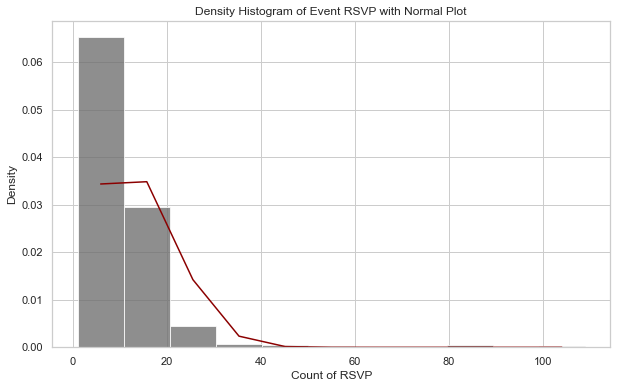

In [8]:
from scipy.stats import norm

figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(events['rsvp_count'], color="DimGray", density=True, bins=11, alpha=0.75)
axes.set_xlabel("Count of RSVP")
axes.set_ylabel("Density")
axes.set_title("Density Histogram of Event RSVP with Normal Plot")

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]    

rings_mean = events["rsvp_count"].mean()
rings_std  = events["rsvp_count"].std()
ys = [norm.pdf( k, loc=rings_mean, scale=rings_std) for k in xs]
axes.plot(xs, ys, color="darkred")

plt.show()
plt.close()

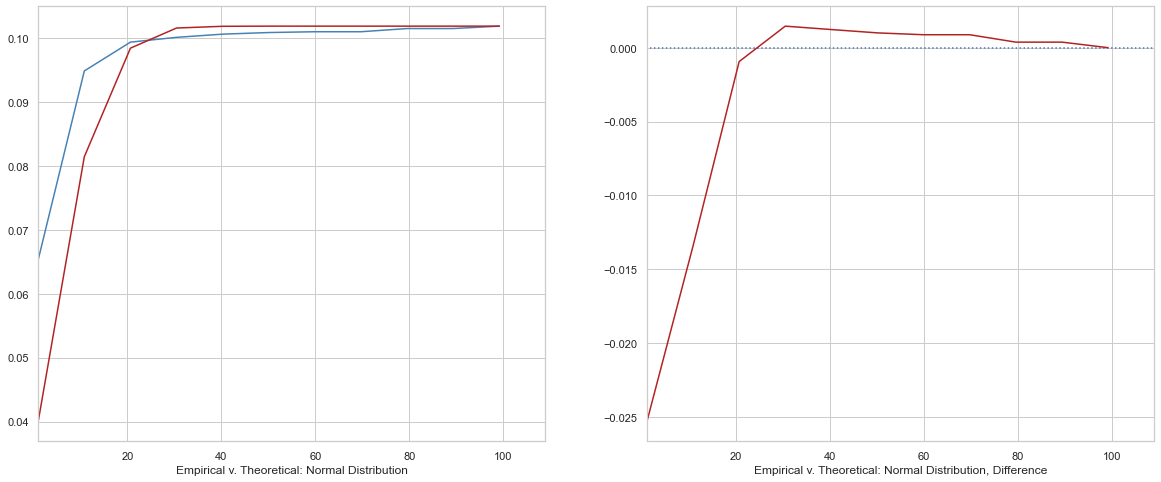

In [9]:
figure = plt.figure(figsize=(20, 8))

abalone_rings_mn = events['rsvp_count'].min()
abalone_rings_mx = events['rsvp_count'].max()

axes = figure.add_subplot(1, 2, 1)

values, base = np.histogram(events['rsvp_count'], bins=11, density=True)
cumulative = np.cumsum(values)
axes.plot(base[:-1], cumulative, color="steelblue")
axes.set_xlim((abalone_rings_mn, abalone_rings_mx))

sampled_data = [rings_mean + r * rings_std for r in np.random.standard_normal(10000)]
values2, base = np.histogram(sampled_data, bins=base, density=True)
cumulative2 = np.cumsum(values2)
axes.plot( base[:-1], cumulative2, color="firebrick")
axes.set_xlim((abalone_rings_mn, abalone_rings_mx))
axes.set_xlabel("Empirical v. Theoretical: Normal Distribution")

axes = figure.add_subplot(1, 2, 2)

differences = cumulative2 - cumulative
axes.plot(base[:-1], differences, color='firebrick')
axes.set_xlim((abalone_rings_mn, abalone_rings_mx))
axes.hlines(0, 0, 14000, linestyles="dotted")
axes.set_xlabel("Empirical v. Theoretical: Normal Distribution, Difference")

plt.show()
plt.close()

Note that the empirical and theoretical plots for normal distribution are very close. The difference chart on the right gives us an estimation and approximation of how close the number of reservation is. Ideally, it'll be nice to have a flat horizontal line about y=0, but here we can see our model is pretty good except around the mean (about 20 RSVPs).

In [10]:
events.rsvp_count.describe()

count    814.000000
mean      10.968059
std       10.296775
min        1.000000
25%        6.000000
50%        9.000000
75%       12.000000
max      109.000000
Name: rsvp_count, dtype: float64

This is a very large range going from one attendee to 109.

In [11]:
def freeman_diaconis( data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    return int( h)

Freeman Diaconis:  1


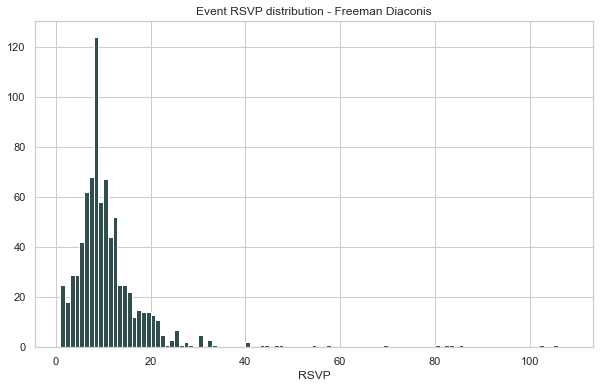

In [12]:
h = freeman_diaconis(events.rsvp_count)
print("Freeman Diaconis: ", h)
mn = int(events.rsvp_count.min())
mx = int(events.rsvp_count.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(events.rsvp_count,bins=bins, color="darkslategray")
axes.set_title("Event RSVP distribution - Freeman Diaconis")
axes.set_xlabel("RSVP")

plt.show()
plt.close()

Let's generate the Bootstrap of the posterior distribution of $\hat{\theta}$. We can write a simple function to do our bootstrap sampling for us. It takes the data, a metric function and the number of bootstrap samples as the arguments. We can then use the function by supplying the Meetup data, our metric function `np.mean` and indicate we want 1000 bootstrap samples. This returns the data we can use as our posterior distribution of the proportion.

In [13]:
def bootstrap_sample( data, f, n=100):
    result = []
    m = len( data)
    for _ in range( n):
        sample = np.random.choice( data, len(data), replace=True)
        r = f( sample)
        result.append( r)
    return np.array( result)

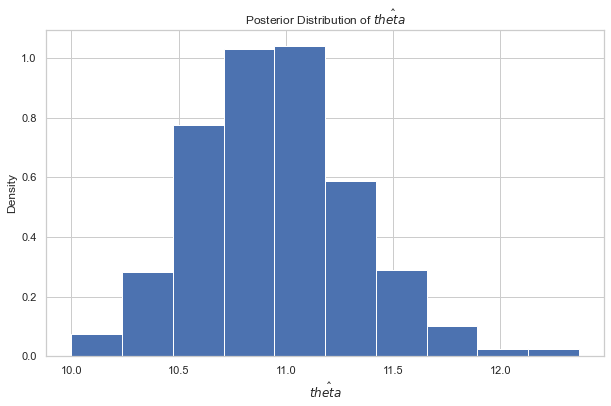

In [14]:
posterior = bootstrap_sample( events.rsvp_count, np.mean, 1000)
figure = plt.figure(figsize=(10, 6)) # first element is width, second is height.

axes = figure.add_subplot(1, 1, 1)

axes.hist( posterior, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "$\hat{theta}$")
axes.set_title( "Posterior Distribution of $\hat{theta}$")

plt.show()
plt.close()

Furthermore, we can find the 90% Credible Interval (Bayesian Confidence Interval) for $\hat{\theta}$

In [15]:
stats.mstats.mquantiles(posterior, [0.05, 0.95])

array([10.37374693, 11.58130221])

There is a 90% probability that the value of $\theta$ is between 10.4 and 11.6 based on the data.

Let's review our pairwise EDA with the target variable, RSVP:

* venue city - definite positive progression but banding suggests an interaction term.
* duration - no relationship at all.
* event time - overall positive

Let's start with a linear model by looking at the correlation coefficients between each variable and the target. First we need these following dummy variables since venue_city and event_time are categorical.

In [16]:
events = pd.concat([events, pd.get_dummies(events["venue_city"], prefix="city")], axis=1)
events = pd.concat([events, pd.get_dummies(events["event_time"], prefix="time")], axis=1)
events.describe()

,rsvp_count,waitlist_count,duration,venue_lat,venue_lon,city_Auburn,city_Beijing,city_Bellevue,city_Bellevue,city_Berlin,...,time_19:15,time_19:30,time_19:45,time_20:00,time_20:30,time_20:45,time_21:00,time_21:15,time_22:00,time_23:59
count,814.000000,814.000000,814.000000,762.000000,762.000000,814.000000,814.000000,814.000000,814.000000,814.000000,...,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000
mean,10.968059,0.108108,2.474918,47.431800,-121.433413,0.001229,0.001229,0.280098,0.007371,0.001229,...,0.003686,0.029484,0.001229,0.013514,0.003686,0.001229,0.006143,0.001229,0.001229,0.001229
std,10.296775,0.853678,2.740083,2.998231,11.537341,0.035050,0.035050,0.449323,0.085590,0.035050,...,0.060634,0.169263,0.035050,0.115530,0.060634,0.035050,0.078181,0.035050,0.035050,0.035050
min,1.000000,0.000000,0.000000,0.000000,-122.519081,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,1.000000,47.598366,-122.325502,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.000000,0.000000,2.000000,47.618492,-122.206394,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12.000000,0.000000,3.000000,47.659306,-122.152388,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,109.000000,13.000000,38.500000,48.415180,116.407394,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
def correlations(data, y, xs):
    rs = []
    rhos = []
    for x in xs:
        r = stats.pearsonr(data[y], data[x])[0]
        rs.append(r)
        rho = stats.spearmanr(data[y], data[x])[0]
        rhos.append(rho)
    return pd.DataFrame({"feature": xs, "r": rs, "rho": rhos})

In the Explore step of the assignment we selected the top four most frequented cities as well as the most common times.

In [18]:
correlations(events, "rsvp_count", ["city_Seattle","city_Issaquah","city_Redmond","city_Bellevue",
                                    "time_16:00","time_18:00","time_10:00","time_19:00", "duration"])

,feature,r,rho
0,city_Seattle,-0.029668,0.005457
1,city_Issaquah,-0.062954,-0.084100
2,city_Redmond,0.025708,0.087630
3,city_Bellevue,0.155868,0.128478
4,time_16:00,0.079179,0.050022
5,time_18:00,0.182046,0.087944
6,time_10:00,-0.007607,0.019013
7,time_19:00,-0.050407,-0.028687
8,duration,0.030478,0.106092


At a glance, there doesn't seem to be any huge relationship or anything linear. Let's attempt a linear a model regression.

In [19]:
import models
model = "rsvp_count ~ duration + city_Seattle"
result1 = models.bootstrap_linear_regression(model, data=events)
models.describe_bootstrap_lr(result1)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,10.93,10.06,12.18
duration,$\beta_{1}$,0.11,-0.03,0.37
city_Seattle,$\beta_{2}$,-0.60,-1.91,0.69
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,
$\sigma$,10.30,8.11,13.08,
$R^2$,0.00,0.00,0.01,


:( I am running into a Python problem where the model cannot process the event time variable.

In [20]:
def plot_residuals(result, variables):
    figure = plt.figure(figsize=(20,6))

    plots = len( variables)
    rows = (plots // 3) + 1

    residuals = np.array([r[0] for r in result["residuals"]])
    limits = max(np.abs(residuals.min()), residuals.max())
    
    n = result["n"]
    for i, variable in enumerate( variables):
        axes = figure.add_subplot(rows, 3, i + 1)

        keyed_values = sorted(zip(events[variable].values, residuals), key=lambda x: x[ 0])
        ordered_residuals = [x[ 1] for x in keyed_values]

        axes.plot(list(range(0, n)), ordered_residuals, '.', color="dimgray", alpha=0.75)
        axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
        axes.set_ylim((-limits, limits))
        axes.set_ylabel("residuals")
        axes.set_xlabel(variable)

    plt.show()
    plt.close()
    
    return residuals

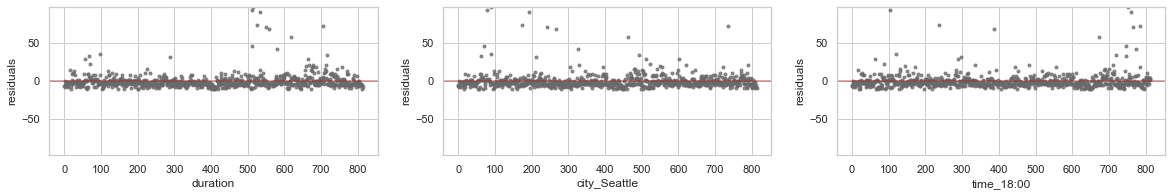

In [21]:
residuals1 = plot_residuals(result1, ["duration", "city_Seattle", "time_18:00"])

We saw earlier that RSVP is not normally distributed and that this might cause some problems but we can correct this by loggify the data.

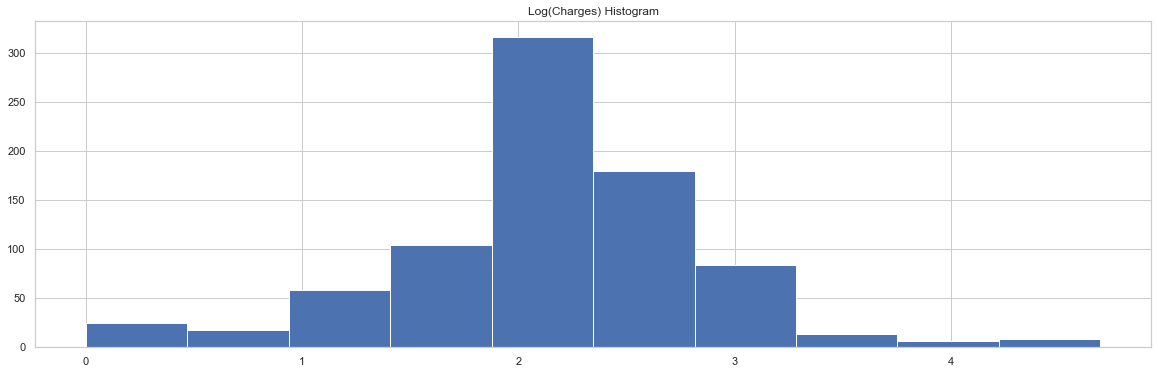

In [22]:
events["log_rsvp"] = events["rsvp_count"].apply(np.log)
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1,1,1)
axes.hist(events.log_rsvp)
axes.set_title("Log(Charges) Histogram")
plt.show()
plt.close()

This looks slightly better than before. It's not exactly normal but is fairly symmetric.

In [23]:
model = "log_rsvp ~ duration + city_Seattle"
result2 = models.bootstrap_linear_regression(model, data=events)
models.describe_bootstrap_lr(result2)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,2.13,2.03,2.20
duration,$\beta_{1}$,0.01,-0.00,0.04
city_Seattle,$\beta_{2}$,-0.00,-0.12,0.10
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,
$\sigma$,0.70,0.66,0.75,
$R^2$,0.00,0.00,0.02,


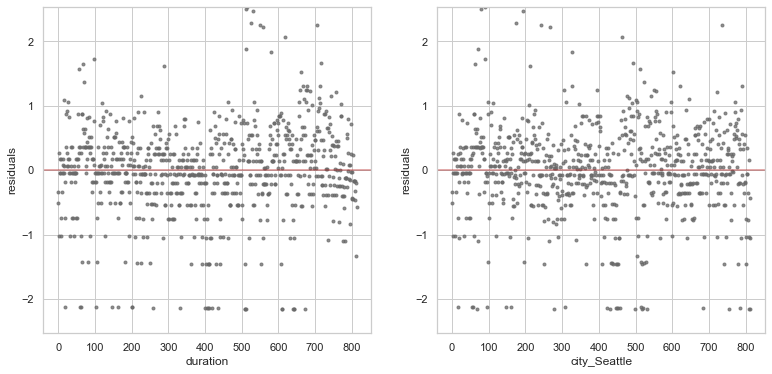

In [24]:
residuals_final= plot_residuals(result2, ["duration", "city_Seattle"])

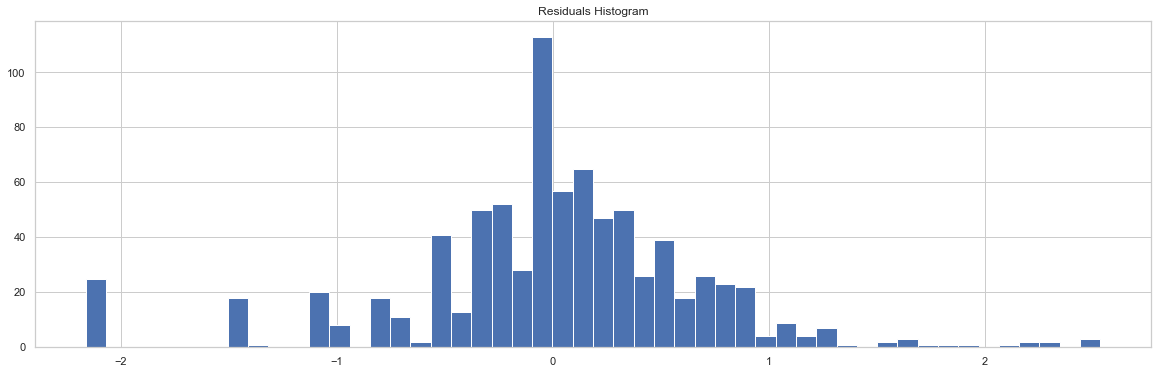

In [25]:
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1,1,1)
axes.hist(residuals_final, bins=50)
axes.set_title("Residuals Histogram")
plt.show()
plt.close()  

To compare this linear model with the null model, we will first want to perform three rounds of 10-fold cross validation, estimating $R^2$ and $\sigma$ each round. Let's have a function that chunks `xs` into `n` chunks and another function that actual does cross validation.

In [26]:
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

In [27]:
def cross_validation(algorithm, formula, data, evaluate, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = []
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            result = algorithm(formula, data=train_data)
            model = result["model"]
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            # y = np.ravel( y) # might need for logistic regression
            results = models.summarize(formula, X, y, model)
            metric = evaluate(results)
            metrics.append(metric)
    return metrics

In [28]:
formula = "rsvp_count ~ duration + city_Seattle"
result = cross_validation(models.linear_regression, formula, events, lambda r: (r["sigma"], r["r_squared"]))

It's unfortunate my formula is bad

In [29]:
print(r"95% CI for sigma:", stats.mstats.mquantiles([r[0] for r in result], [0.025, 0.975]))
print(r"95% CI for R^2:", stats.mstats.mquantiles([r[1] for r in result], [0.025, 0.975]))

95% CI for sigma: [ 5.07680505 16.32984892]
95% CI for R^2: [-0.14224067  0.01117915]


I wanted to evaluated this model against the data it was tested where the 10 fold cross validation simulates the application of the model against data that was not used to train it

The 10 fold cross validation results simulate the range of results we should expect to see and this is not looking good for us. :(

The following functions are all taken from course lab solutions.

In [30]:
from collections import defaultdict

def data_collection():
    result = dict()
    result[ "train"] = defaultdict( list)
    result[ "test"] = defaultdict( list)
    return result

def learning_curves(algorithm, formula, data, evaluate, fold_count=10, repetitions=3, increment=1):
    indices = list(range(len( data)))
    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i in list(range(increment, 100, increment)) + [100]: # ensures 100% is always picked.
                # the indices are already shuffled so we only need to take ever increasing chunks
                train_chunk_size = int( np.ceil((i/100)*len( train_indices)))
                train_data_chunk = data.iloc[train_indices[0:train_chunk_size]]
                # we calculate the model
                result = algorithm(formula, data=train_data_chunk)
                model = result["model"]
                # we calculate the results for the training data subset
                y, X = patsy.dmatrices( formula, train_data_chunk, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["train"][i].append( metric)
                
                # we calculate the results for the test data.
                y, X = patsy.dmatrices( formula, test_data, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["test"][i].append( metric)
            #
        #
    # process results
    # Rely on the CLT...
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results

def results_to_curves( curve, results):
    all_statistics = results[ curve]
    keys = list( all_statistics.keys())
    keys.sort()
    mean = []
    upper = []
    lower = []
    for k in keys:
        m, s = all_statistics[ k]
        mean.append( m)
        upper.append( m + 2 * s)
        lower.append( m - 2 * s)
    return keys, lower, mean, upper

def plot_learning_curves( results, metric, zoom=False):
    figure = plt.figure(figsize=(10,6))

    axes = figure.add_subplot(1, 1, 1)

    xs, train_lower, train_mean, train_upper = results_to_curves( "train", results)
    _, test_lower, test_mean, test_upper = results_to_curves( "test", results)

    axes.plot( xs, train_mean, color="steelblue")
    axes.fill_between( xs, train_upper, train_lower, color="steelblue", alpha=0.25, label="train")
    axes.plot( xs, test_mean, color="firebrick")
    axes.fill_between( xs, test_upper, test_lower, color="firebrick", alpha=0.25, label="test")
    axes.legend()
    axes.set_xlabel( "training set (%)")
    axes.set_ylabel( metric)
    axes.set_title("Learning Curves")

    if zoom:
        y_lower = int( 0.9 * np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = int( 1.1 * np.amax([train_upper[-1], test_upper[-1]]))
        axes.set_ylim((y_lower, y_upper))

    plt.show()
    plt.close()

In [31]:
formula = "rsvp_count ~ city_Seattle"
result = learning_curves(models.linear_regression, formula, events, lambda r: r["sigma"])

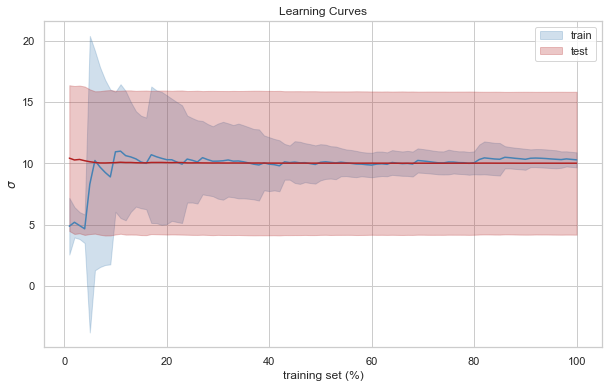

In [32]:
plot_learning_curves(result, r"$\sigma$")

Despite the bad model, the curves (red and blue lines) converged. We can attempt to validate these curves. Let's split the testing and training data and fit the decision tree to predict some charges.

In [33]:
from sklearn.model_selection import train_test_split
from sklearn import tree

y = events['rsvp_count']
X = events[['city_Seattle', 'city_Redmond', 'city_Bellevue']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)
clf = tree.DecisionTreeRegressor(random_state=0)
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.014441419978661107

Let's use validation curves to estimate the best tree depth

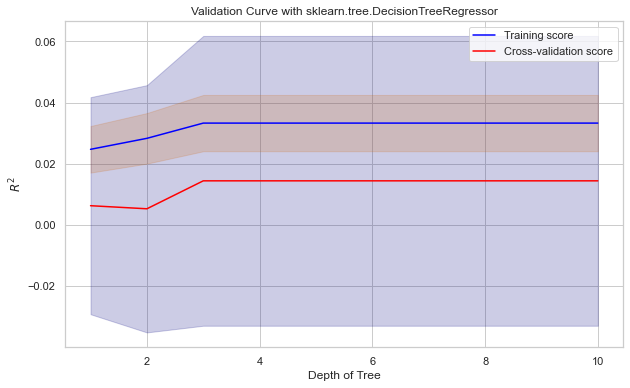

In [34]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import validation_curve

# Depth of one to ten
param_range = range(1, 11)

train_scores, test_scores = validation_curve(
    tree.DecisionTreeRegressor(),
    X,
    y,
    param_name="max_depth",
    param_range=param_range,
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize = (10,6))
plt.title(f"Validation Curve with sklearn.tree.DecisionTreeRegressor")
plt.xlabel("Depth of Tree")
plt.ylabel("$R^2$")
plt.plot(param_range, train_scores_mean, label="Training score", color="blue")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="darkorange")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="navy")
plt.legend()

Doesn't appear to be an optimal depth. Let's see how this model does.

In [35]:
from sklearn.metrics import r2_score

# 4 is assume to be the optimal depth from the validation curves above
regressor = DecisionTreeRegressor(max_depth = 4)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
r2_score(y_test, y_pred)  

0.014441419978661107

This model is crap but it's still better than...

In [36]:
model = "rsvp_count ~ duration + city_Seattle"
result1 = models.bootstrap_linear_regression(model, data=events)
models.describe_bootstrap_lr(result1)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,10.93,9.96,11.96
duration,$\beta_{1}$,0.11,-0.02,0.32
city_Seattle,$\beta_{2}$,-0.60,-1.71,0.55
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,
$\sigma$,10.30,7.62,12.37,
$R^2$,0.00,0.00,0.01,


Let's look at the feature importance. First thing we want to do is ge the numerical feature importances and then make a list of tuples with the variables and their importance.

In [37]:
feature_list = list(X.columns)
importances = list(regressor.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort and print the feature importances
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: city_Bellevue        Importance: 0.8
Variable: city_Seattle         Importance: 0.11
Variable: city_Redmond         Importance: 0.09


This is interesting. I thought Seattle would be more important as there are more fun activities to host there.

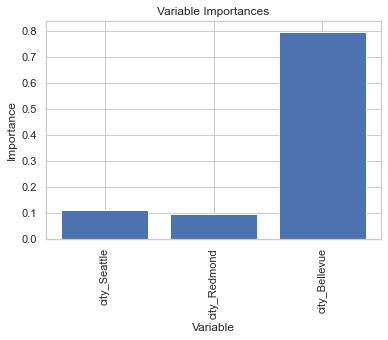

In [38]:
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

This could be an indication that members are likely to RSVP if the event took place in Bellevue.